# Importing Sibilla
**Sibilla Project Setup and Build**

This cell performs the following operations:

1. Update package lists:
   Ensures the system has the latest information about available packages:
   ```
   !apt-get update
   ```
2. Install OpenJDK 21:
   Installs an up-to-date Java Development Kit necessary for building the project.
   ```
   !apt-get install openjdk-21-jdk
   ```

3. Clone the Sibilla repository:
   Fetches the latest version of the Sibilla project from GitHub.
   ```
   !git clone https://github.com/quasylab/sibilla
   ```

4. Build the Sibilla project:
   ```
   !cd sibilla && ./gradlew build installDist -x test --parallel
   ```
   - Changes to the Sibilla directory
   - Runs Gradle to build the project and create distribution
   - Skips tests (-x test) to speed up the build process
   - Uses parallel execution (--parallel) to improve build speed on multi-core systems

5. Copy the Sibilla Python scripts:
   Makes the Python interface for Sibilla available in the current directory.
   ```
   !cp -a sibilla/shell/src/dist/scripts/sibilla_py .
   ```

6. Install the Sibilla Python package:
   Makes the Sibilla Python interface available for use in this Colab environment.
   ```
   !cd sibilla_py && pip install .
   ```

After running this cell, Sibilla will be built and its Python interface
will be available for use in subsequent cells of this Colab notebook.

**Note on timing**: This entire process typically takes about **5-6 minutes** to complete. Actual duration may vary based on current Colab resource allocation and network conditions.

In [ ]:
!apt-get update
!apt-get install openjdk-21-jdk
!git clone https://github.com/quasylab/sibilla
!cd sibilla && ./gradlew build installDist -x test --parallel
!cp -a sibilla/shell/src/dist/scripts/sibilla_py .
!cd sibilla_py && pip install .

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,030 kB]
Get:14 http://securit

In [ ]:
import os
os.environ["SSHELL_PATH"]="/content/sibilla/shell/build/install/sshell/"
import sibilla

# Plotting Methods

In [52]:
import matplotlib.pyplot as plt

def plot_results(red_counts, blue_counts, mal_for_each, unc_for_each):
    categories = ['0', '1', '2', '3', '4', 'Mal', 'Unc']
    red_values = list(red_counts.values()) + [0, 0]  # Add zeros for Mal and Unc
    blue_values = list(blue_counts.values()) + [0, 0]  # Add zeros for Mal and Unc
    mal_values = [0, 0, 0, 0, 0, mal_for_each, 0]  # Zeros for 0-4, then mal_for_each, then 0 for Unc
    unc_values = [0, 0, 0, 0, 0, 0, unc_for_each]  # Zeros for 0-4 and Mal, then unc_for_each

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(categories, red_values, label='Red', color='red', alpha=0.7)
    ax.bar(categories, blue_values, bottom=red_values, label='Blue', color='blue', alpha=0.7)
    ax.bar(categories, mal_values, bottom=[r+b for r,b in zip(red_values, blue_values)], label='Malicious', color='gray', alpha=0.7)
    ax.bar(categories, unc_values, bottom=[r+b+m for r,b,m in zip(red_values, blue_values, mal_values)], label='Uncertain', color='darkgreen', alpha=0.7)

    y_limit = max(17, 0.1 * (mal_for_each + unc_for_each))
    ax.set_ylim(0, y_limit)

    ax.set_ylabel('Count')
    ax.set_xlabel('Category')
    ax.set_title('Distribution of Counts by compartment')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_results(red_counts, blue_counts, mal_for_each, unc_for_each)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def select_samples(df, result_column, N, epsilon):
    df_sorted = df.sort_values(by=result_column)

    min_val = df_sorted[result_column].min()
    max_val = df_sorted[result_column].max()
    mean_val = df_sorted[result_column].mean()

    low_samples = df_sorted[(df_sorted[result_column] >= min_val) & (df_sorted[result_column] <= min_val + epsilon)].head(N)
    mid_samples = df_sorted[(df_sorted[result_column] >= mean_val - epsilon/2) & (df_sorted[result_column] <= mean_val + epsilon/2)].head(N)
    high_samples = df_sorted[(df_sorted[result_column] >= max_val - epsilon) & (df_sorted[result_column] <= max_val)].tail(N)

    selected_samples = pd.concat([low_samples, mid_samples, high_samples])

    return selected_samples

def parallelCoordinatesPlot(N, data, ynames, title="", inverse_scaling=False, max_line_width=7.0, cmap=plt.cm.viridis, color_range=(0, 1), opacity=1.0):
    fig, host = plt.subplots(figsize=(14, 7))

    ys = np.array(data).T  # Transpose the data for easier manipulation

    # Separate 'result' from other data
    result_index = ynames.index('result')
    result_data = ys[:, result_index]
    other_data = np.delete(ys, result_index, axis=1)
    other_names = [name for name in ynames if name != 'result']

    # Scale other data between 0 and 1
    other_data = (other_data - other_data.min(axis=0)) / (other_data.max(axis=0) - other_data.min(axis=0))

    # Combine scaled data with original result data
    ys = np.insert(other_data, result_index, result_data, axis=1)

    # Calculate line widths based on result values
    min_result = np.min(result_data)
    max_result = np.max(result_data)
    if inverse_scaling:
        line_widths = max_line_width - (max_line_width - 1.0) * (result_data - min_result) / (max_result - min_result)
    else:
        line_widths = 1.0 + (max_line_width - 1.0) * (result_data - min_result) / (max_result - min_result)

    axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
    for i, ax in enumerate(axes):
        if i == result_index:
            ax.set_ylim(result_data.min(), result_data.max())
        else:
            ax.set_ylim(0-0.1, 1+0.1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

    host.set_xlim(0, ys.shape[1] - 1)
    host.set_xticks(range(ys.shape[1]))
    host.set_xticklabels(ynames, fontsize=10, rotation=45, ha='left')
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_top()
    if title:
        host.set_title(title, fontsize=18, pad=20)

    color_start, color_end = color_range
    if inverse_scaling:
        colors = cmap(np.linspace(color_end, color_start, N))
    else:
        colors = cmap(np.linspace(color_start, color_end, N))

    for j in range(N):
        verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                         np.repeat(ys[j, :], 3)[1:-1]))
        codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=line_widths[j], edgecolor=colors[j])
        host.add_patch(patch)

    plt.tight_layout()
    plt.show()

In [ ]:
    #colors = plt.cm.viridis(np.linspace(0, 1, N))
    colors = plt.cm.plasma(np.linspace(0, 1, N))
    #colors = plt.cm.Greys(np.linspace(0, 1, N+10))
    #colors = plt.cm.Blues(np.linspace(0, 5, N+5))

# Comparative Synthesis Task YAML Specification

This document explains the YAML specification for a comparative synthesis task, which involves analyzing and optimizing the relationship between two models: an original model and a variant model.


## Detailed Explanation

### 1. synthesisStrategy

#### 1.1 searchSpace
Defines the parameters and their bounds for the search:
- `x`: ranges from -1.0 to 1.0
- `y`: ranges from -1.0 to 1.0

#### 1.2 sampling
Specifies the sampling method:
- Name: "lhs" (Latin Hypercube Sampling)
- Dataset size: 1000 samples

#### 1.3 surrogate
Defines the surrogate model:
- Name: "rf" (Random Forest)
- Training portion: 90% of the dataset
- Properties:
  - Number of trees: 300
  - Maximum depth: 200

#### 1.4 optimization
Describes the optimization method:
- Name: "pso" (Particle Swarm Optimization)
- Constraints:
  - `x + y <= 1.0`
  - `x + y >= -0.5`
- Properties:
  - Number of iterations: 1000
  - Number of particles: 500

#### 1.5 infill
Specifies the infill strategy:
- Threshold: 0.1
- Maximum iterations: 10

### 2. synthesisTask

#### 2.1 type
Set to "comparative", indicating a task that compares two models.

#### 2.2 taskSpecs
Describes the specifics of the comparative task:

- `objective`: Can be "preserve", "diverge", or "improve". This determines the goal of the comparison:
  - "preserve": Tune parameters to make the variant model as similar as possible to the original.
  - "diverge": Maximize the difference between the variant and original models.
  - "improve": Tune parameters so the variant model performs better than the original.

- `distanceType`: "minkowski" - Specifies the distance metric used for comparison.

- `p`: 3 - The parameter for the Minkowski distance (p=1 for Manhattan, p=2 for Euclidean, p→∞ for Chebyshev).

- `modelOriginal` and `modelVariant`: Specifications for the two models being compared:
  - `module`: "population" for both models
  - `initialConfiguration`: "initial" for both models
  - `modelSpecification`: Detailed model descriptions (placeholder in this example)

- `formulae`: The set of logical-time formulas used to evaluate both models (placeholder in this example)


for example :


```
synthesisStrategy:
  searchSpace:
    - parameterName: "x"
      lowerBound: -1.0
      upperBound: 1.0
    - parameterName: "y"
      lowerBound: -1.0
      upperBound: 1.0
  sampling:
      name: "lhs"
      datasetSize: 1000
  surrogate:
      name: "rf"
      trainPortion: 0.9
      properties:
        - name: "numberOfTrees"
          value: "300"
        - name: "maxDepth"
          value: "200"
  optimization:
    name: "pso"
    constraints:
      - constraint: "x + y <= 1.0"
      - constraint: "x + y >= -0.5"
    properties:
      - name: "iteration"
        value: "1000"
      - name: "particle_number"
        value: "500"
  infill:
    threshold: 0.1
    maxIteration: 10

synthesisTask:
  type: "comparative"

  taskSpecs:
    objective: "preserve"  # or "diverge" or "improve"
    distanceType: "minkowski"
    p : 3
    modelOriginal:
      module: "population"
      initialConfiguration: "initial"
      modelSpecificationPath: "theActualPath"
      modelSpecification: |
        line 1
        line 2
        line 3
        line 4
        ...
    modelVariant:
      module: "population"
      initialConfiguration: "initial"
      modelSpecification: |
        line 1
        line 2
        line 3
        line 4
        ...
    formulae: |
        line 1
        line 2
        line 3
        line 4
        ...
```




## Usage Notes

1. This specification is designed for comparing two models: an original model and a variant model.


2. Both models are evaluated using the same set of formulas specified in the `formulae` section.

This comparative synthesis task allows for sophisticated analysis of model variations, enabling preservation of behavior, intentional divergence, or targeted improvements relative to a baseline model.

# Sampling Methods


The framework provides different sampling methods for generating points in the search space. Here are the available sampling methods:

### 1. Latin Hypercube Sampling (Algorithm name: "lhs")

Implemented in LatinHyperCubeSamplingTask.java

Description: Latin Hypercube Sampling (LHS) is a stratified sampling method that provides better coverage of the sample space compared to simple random sampling. It ensures that each of the input variables has all portions of its distribution represented by input values.

Usage: Specify the **number of samples directly**.

### 2. Full Factorial Sampling (Algorithm name: "ffs")

Implemented in FullFactorialSamplingTask.java

Description: Full Factorial Sampling creates a grid of evenly spaced points over the search space. It provides complete coverage of the space but can result in a large number of samples, especially in high-dimensional spaces.

Usage: Specify the **number of samples per dimension**, not the total number of samples. The total number of samples will be (samples per dimension)^(number of dimensions).

### 3. Random Sampling (Algorithm name: "rs")

Implemented in RandomSamplingTask.java

Description: Random Sampling generates points randomly from a uniform distribution over the search space. It's simple to implement and can work well for low-dimensional spaces, but may not provide even coverage in higher dimensions.

Usage: Specify the **number of samples directly**.



# Available Optimization Algorithms and Their Properties

This document provides an overview of the optimization algorithms implemented in the given Java classes, along with their configurable properties. Each algorithm is referred to by a specific name in the system.

## 1. MADS (Mesh Adaptive Direct Search)

MADS is implemented in two variants: LTMADS and OrthoMADS.

### 1.1 LTMADS (Algorithm name: "ltmads")

Properties:
- `delta_mesh` (default: 1.0): Initial mesh size
- `delta_poll` (default: 1.0): Initial poll size
- `tau` (default: 0.25): Mesh update factor
- `epsilon` (default: 1.0E-50): Convergence tolerance
- `iteration` (default: 500): Maximum number of iterations
- `search_points` (default: 20): Number of search points
- `opportunistic` (default: false): Whether to use opportunistic evaluation
- `minimal_basis` (default: true): Whether to use minimal positive basis

### 1.2 OrthoMADS (Algorithm name: "orthomads")

OrthoMADS uses the same properties as LTMADS, except it doesn't have the `mads.minimal_basis` option.

## 2. PSO (Particle Swarm Optimization) (Algorithm name: "pso")

Implemented in PSOTask.java

Properties:
- `inertia` (default: 0.72984): Inertia weight
- `self_confidence` (default: 1.49617): Cognitive component
- `swarm_confidence` (default: 1.49617): Social component
- `particles_number` (default: 100): Number of particles in the swarm
- `iteration` (default: 100): Number of iterations

## 3. Simulated Annealing (Algorithm name: "sa")

Implemented in SimulatedAnnealingTask.java

Properties:
- `max_iterations` (default: 1000): Maximum number of iterations
- `initial_temperature` (default: 1000.0): Initial temperature
- `cooling_rate` (default: 0.003): Cooling rate
- `cooling_schedule` (default: "linear"): Cooling schedule type. Options are:
  - "linear": Linear cooling schedule
  - "exponential": Exponential cooling schedule
  - "logarithmic": Logarithmic cooling schedule



# Available Surrogates and Their Properties

In addition to the optimization algorithms, the system also provides surrogate models for function approximation. Here are the available surrogate models:

### 1. Random Forest (Algorithm name: "rf")

Implemented in RandomForestModel.java

Properties:
- `trees` (default: 500): Number of trees in the forest
- `mtry` (default: max(features/3, 1)): Number of random features to consider in each split
- `max_depth` (default: 200): Maximum depth of the trees
- `max_nodes` (default: training_set_size/5): Maximum number of leaf nodes
- `node_size` (default: 5): Minimum number of instances in leaf nodes
- `rate` (default: 1.0): Subsample rate for training data

### 2. Gradient Tree Boost (Algorithm name: "gtb")

Implemented in GradientTreeBoostModel.java

Properties:
- `trees` (default: 500): Number of trees
- `loss` (default: "LeastAbsoluteDeviation"): Loss function for regression
- `max_depth` (default: 20): Maximum depth of the trees
- `max_nodes` (default: 6): Maximum number of leaf nodes
- `node_size` (default: 5): Minimum number of instances in leaf nodes
- `shrinkage` (default: 0.05): Learning rate
- `sample_rate` (default: 0.7): Subsample rate for stochastic tree boosting

### 3. Radial Basis Function Network (Algorithm name: "rbf")

Implemented in RBFNetworkModel.java

Properties:
- `neurons` (default: features * 10): Number of RBF neurons
- `normalized` (default: false): Whether to normalize the network




# Three-State Protocol (TSP)
Three-State Protocol (TSP) Consensus Mechanism: A Comparative Case Study
Introduction
This case study examines a Three-State Protocol (TSP) consensus mechanism, comparing an original model to a spatially-structured variant. The study focuses on optimizing initial conditions to achieve specific behavioral characteristics.
Model Descriptions
###Original Model

Entities move freely in a common space (fully connected network)
Three main states: Red, Blue, and Uncertain
Additional Malicious (Mal) state can disrupt consensus
If Malicious entities exceed 50%, the entire system halts
The initial state of the original one is
- RED : 10
- BLUE : 10
- UNC : 75
- MAL : 5

###Variant Model

Introduces spatial structure with 5 interconnected nodes
Same states as the original model
If Malicious entities exceed 50% in a single node, only that node halts
Allows for more nuanced dynamics and potential recovery scenarios

###Optimization Parameters
The parameter vector $\Theta$ consists of:

Initial percentage of reds in each node:
$$\text{RED}_{\%}[i] \text{ for } i \in {0,1,2,3,4}$$
Initial percentage of malicious entities:
$$\text{MAL}_{\%}$$

Thus, the complete parameter vector is:
$$\Theta = (\text{RED}{\%}[0], \text{RED}{\%}[1], \text{RED}{\%}[2], \text{RED}{\%}[3], \text{RED}{\%}[4], \text{MAL}{\%})$$
Calculation of Entity Numbers
Red and Blue Entities
For each node $i$:
$$\text{RED}[i] = \text{RED}{\%}[i] \cdot \frac{\sum{i=0}^{K-1}(\text{RED}[i] + \text{BLUE}[i])}{K}$$
$$\text{BLUE}[i] = (1.0 - \text{RED}{\%}[i]) \cdot \frac{\sum{i=0}^{K-1}(\text{RED}[i] + \text{BLUE}[i])}{K}$$
Where $K$ is the number of nodes (5 in this case).
Malicious and Uncertain Entities
For each node $i$:
$$\text{MAL}[i] = \text{MAL}{\%} \cdot \frac{\sum{i=0}^{K-1}(\text{MAL}[i] + \text{UNC}[i])}{K}$$
$$\text{UNC}[i] = (1.0 - \text{MAL}{\%}) \cdot \frac{\sum{i=0}^{K-1}(\text{MAL}[i] + \text{UNC}[i])}{K}$$
###Optimization Problem
Search Space
$${ \text{RED}{\%}[0], \text{RED}{\%}[1], \text{RED}{\%}[2], \text{RED}{\%}[3], \text{RED}{\%}[4], \text{MAL}{\%}) \in \mathbb{R}^6 \mid 0.1 \leq \text{RED}{\%}[i] \leq 1.0 \text{ for } i \in {0,1,2,3,4}, \text{ and } 0.0 \leq \text{MAL}{\%} \leq 1.0 } $$
Constraint
$$1.5 \leq \sum_{i=0}^4 \text{RED}_{\%}[i] \leq 3.5$$
Objective
The optimization aims to find the optimal $\Theta$ within the defined search space $\mathcal{H}$, subject to the given constraint. The specific objective (preserve, diverge, or improve) would be defined based on the desired relationship between the original and variant models.


###Key Properties for Evaluation
The comparison between the original and variant models focuses on the following key properties, expressed as temporal logic formulas:

RED Dominance:
$$\varphi_1(t) = \lozenge_{\left [ 0,t \right ]}\left (\text{Red}_{(\%)} \geq 1.0\right )$$
This formula assesses whether RED entities ever achieve complete dominance within the time interval [0, t].
RED Overwhelming Majority:
$$\varphi_2(t) = \left ( \text{Red}{(\%)} > 3 \cdot \text{Blue}{(\%)} \right )\wedge \lozenge_{\left [ 0,t \right ]}\left ( \text{Blue}_{(\%)} \leq 0.0\right )$$
This formula examines a scenario where RED entities significantly outnumber BLUE entities (more than 3 to 1 ratio), eventually leading to BLUE's disappearance within the time interval [0, t].
Consistent RED Majority:
$$\varphi_3(t) = \Box_{\left [ 0,t \right ]}\left ( \text{Red}_{(\%)} \geq 0.5\right )$$
This formula ensures a consistent majority presence of RED entities (at least 50%) throughout the entire observed period [0, t].
Malicious Entity Evolution:
$$\varphi_4(t) = \lozenge_{\left [ 0, \frac{t}{4} \right ]} \left ( \text{Mal}{(\%)} \geq 0.05 \right ) \leftrightarrow   \Box{\left [ \frac{3t}{4}, t \right ]} \left ( \text{Mal}_{(\%)} \geq 0.25 \right )$$
This formula explores the relationship between early appearance and later proliferation of malicious entities. It states that if malicious entities reach 5% in the first quarter of the time interval, then they will consistently be above 25% in the last quarter of the interval, and vice versa.

These formulas allow for a comprehensive evaluation of the dynamics in both the original and variant models, focusing on different aspects of entity populations and their evolution over time.

In [5]:
sr = sibilla.SibillaRuntime()

##Preserve

In [55]:
preserve_spec = '''
synthesisStrategy:
  searchSpace:
    - parameterName: "redFractionIn0"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn1"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn2"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn3"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn4"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "malFractionForEach"
      lowerBound: 0.0
      upperBound: 1.0
  optimization:
    name: "pso"
    constraints:
      - constraint: "redFractionIn0 + redFractionIn1 + redFractionIn2 +redFractionIn3 +redFractionIn4 <= 3.5"
      - constraint: "redFractionIn0 + redFractionIn1 + redFractionIn2 +redFractionIn3 +redFractionIn4 >= 1.5"
    properties:
      - name: "iteration"
        value: "1000"
  sampling:
    name: "lhs"
    datasetSize: 500

synthesisTask:
  type: "comparative"

  simulationSetting:
    replica: 50

  taskSpecs:
      objective: "preserve"
      distanceType: "euclidian"
      modelOriginal:
        module: "population"
        initialConfiguration: "initial"
        modelSpecification: |
          species RED;
          species BLUE;
          species UNC;
          species MAL;

          const persuasion_rate = 1.0;
          param becoming_malevolent = 0.1;

          rule UNC_to_BLUE {
            UNC-[ (%MAL>=0.5? 0:1) * #UNC * persuasion_rate * %BLUE ]-> BLUE
          }

          rule UNC_to_RED {
            UNC -[ (%MAL>=0.5? 0:1) * #UNC * persuasion_rate * %RED ]-> RED
          }

          rule UNC_to_MAL  {
            UNC-[#UNC * persuasion_rate * %MAL ]-> MAL
          }

          rule BLUE_to_UNC {
            BLUE -[ (%MAL>=0.5? 0:1) * #BLUE * persuasion_rate * %RED ]-> UNC
          }

          rule RED_to_UNC {
            RED -[ (%MAL>=0.5? 0:1) * #RED * persuasion_rate * %BLUE ]-> UNC
          }

          measure R = %RED;
          measure B = %BLUE;
          measure U = %UNC;
          measure M = %MAL;

          system initial = RED<10>|BLUE<10>|UNC<75>|MAL<5>;
      modelVariant:
        module: "population"
        initialConfiguration: "initial"
        modelSpecification: |
          const K = 5;       /* length of the ring */

          species RED of [0,K];
          species BLUE of [0,K];
          species UNC of [0,K];
          species MAL of [0,K];

          const persuasion_rate = 3.0; /* persuasion rate */
          const becoming_malevolent = 0.1;

          const totalRedAndBlue = 20;
          const totalUncAndMal = 80;

          param redFractionIn0 = 0.5;
          param redFractionIn1 = 0.5;
          param redFractionIn2 = 0.5;
          param redFractionIn3 = 0.5;
          param redFractionIn4 = 0.5;

          const redQuantityIn0 = redFractionIn0 * totalRedAndBlue / K;
          const redQuantityIn1 = redFractionIn1 * totalRedAndBlue / K;
          const redQuantityIn2 = redFractionIn2 * totalRedAndBlue / K;
          const redQuantityIn3 = redFractionIn3 * totalRedAndBlue / K;
          const redQuantityIn4 = redFractionIn4 * totalRedAndBlue / K;

          const blueQuantityIn0 = (1.0-redFractionIn0) * totalRedAndBlue / K;
          const blueQuantityIn1 = (1.0-redFractionIn1) * totalRedAndBlue / K;
          const blueQuantityIn2 = (1.0-redFractionIn2) * totalRedAndBlue / K;
          const blueQuantityIn3 = (1.0-redFractionIn3) * totalRedAndBlue / K;
          const blueQuantityIn4 = (1.0-redFractionIn4) * totalRedAndBlue / K;

          param malFractionForEach = 0.0;

          const uncQuantityInEach = (1.0-malFractionForEach) * totalUncAndMal /K;
          const malQuantityInEach = malFractionForEach * totalUncAndMal /K;

          rule UNC_to_BLUE for i in [0,K] {
            UNC[i]-[ (%MAL[i]>=0.5? 0:1) * #UNC[i] * persuasion_rate * (%BLUE[i] + %BLUE[(i+1)%K] + %BLUE[(i-1+K)%K])/3 ]-> BLUE[i]
          }

          rule UNC_to_RED for i in [0,K] {
            UNC[i]-[(%MAL[i]>=0.5? 0:1) * #UNC[i] * persuasion_rate * (%RED[i] + %RED[(i+1)%K] + %RED[(i-1+K)%K])/3 ]-> RED[i]
          }

          rule UNC_to_MAL for i in [0,K] {
            UNC[i]-[#UNC[i] * persuasion_rate * %MAL[i] ]-> MAL[i]
          }

          rule BLUE_to_UNC for i in [0,K] {
            BLUE[i]-[ (%MAL[i]>=0.5? 0:1) * #BLUE[i] * persuasion_rate * (%RED[i] + %RED[(i+1)%K] + %RED[(i-1+K)%K])/3 ]-> UNC[i]
          }

          rule RED_to_UNC for i in [0,K] {
            RED[i]-[ (%MAL[i]>=0.5? 0:1) * #RED[i] * persuasion_rate * (%BLUE[i] + %BLUE[(i+1)%K] + %BLUE[(i-1+K)%K])/3 ]-> UNC[i]
          }

          measure R = %RED[0] + %RED[1] + %RED[2] + %RED[3] + %RED[4];
          measure B = %BLUE[0] + %BLUE[1] + %BLUE[2] + %BLUE[3] + %BLUE[4];
          measure U = %UNC[0] + %UNC[1] + %UNC[2] + %UNC[3] + %UNC[4];
          measure M = %MAL[0] + %MAL[1] + %MAL[2] + %MAL[3] + %MAL[4];

          system initial = RED[0]<redQuantityIn0>|RED[1]<redQuantityIn1>|RED[2]<redQuantityIn2>|RED[3]<redQuantityIn3>|RED[4]<redQuantityIn4>|BLUE[0]<blueQuantityIn0>|BLUE[1]<blueQuantityIn1>|BLUE[2]<blueQuantityIn2>|BLUE[3]<blueQuantityIn3>|BLUE[4]<blueQuantityIn4>|UNC[0]<uncQuantityInEach>|UNC[1]<uncQuantityInEach>|UNC[2]<uncQuantityInEach>|UNC[3]<uncQuantityInEach>|UNC[4]<uncQuantityInEach>|MAL[0]<malQuantityInEach>|MAL[1]<malQuantityInEach>|MAL[2]<malQuantityInEach>|MAL[3]<malQuantityInEach>|MAL[4]<malQuantityInEach>;

      formulae: |
        measure R
        measure B
        measure M
        formula formula_stability [t=25.0] : \E[0,t][ R >= 1.0 ]   endformula
        formula formula_coherence [t=25.0] : ([ R > 3 * B ]&&(\E[0,t][ B <= 0.0])) endformula
        formula formula_red_pres [t=25.0] : (\G[0,t][ R >= 0.5]) endformula
        formula formula_mal_pres [t=25.0] : ((\E[0, 1/4 * t]([M >= 0.01]))<->(\G[3/4 * t,t]([M >= 0.25] && [M <= 0.75]))) endformula

'''

syn_rec_pres = sr.perform_synthesis(preserve_spec)
print(syn_rec_pres)

Optimal Coordinates: {'redFractionIn0': 0.7128049360218222, 'redFractionIn1': 0.41309816341726163, 'redFractionIn2': 0.6980298857669558, 'malFractionForEach': 0.10437274825863851, 'redFractionIn3': 0.3679774064452018, 'redFractionIn4': 0.228285438789408}
Optimal Value (Objective Function): 0.1645072087429457
Optimal Value (Surrogate Function): 0.15670041872600013


### Result

The variant model demonstrates successful preservation of the original model's behavior with respect to the given formulas. Let's analyze each aspect:
Both models start with an equal number of RED and BLUE entities (10 each). This balance is key for the evaluation of formulas φ1, φ2, and φ3, which focus on RED dominance and majority.
Malicious Entity Presence:
The variant model slightly increases the number of MAL entities from 5 to 10, but maintains a similar proportion (5% to 10%). This change is small enough to preserve the overall behavior while allowing for the spatial distribution across nodes. This is relevant for formula φ4, which examines the evolution of malicious entities.

In [56]:
preserve_optimal_coordinates = syn_rec_pres.optimal_coordinates()

red_fractions = {
    f'red_{i}_opt_p': preserve_optimal_coordinates[f'redFractionIn{i}']
    for i in range(5)
}

mal_opt_p = preserve_optimal_coordinates['malFractionForEach']

red_counts = {
    f'red_in_{i}_p': round(red_fractions[f'red_{i}_opt_p'] * 4)
    for i in range(5)
}

blue_counts = {
    f'blue_in_{i}_p': 4 - red_counts[f'red_in_{i}_p']
    for i in range(5)
}

mal_for_each = round(mal_opt_p * 16)
unc_for_each = 16 - mal_for_each

print('Red Total')
print(f"Total: {sum(red_counts.values())}")
print(*red_counts.values())

print('\nBlue Total')
print(f"Total: {sum(blue_counts.values())}")
print(*blue_counts.values())

print('\nMalicious for each')
print(mal_for_each)

print('\nUncertain for each')
print(unc_for_each)

Red Total
Total: 10
3 2 3 1 1

Blue Total
Total: 10
1 2 1 3 3

Malicious for each
2

Uncertain for each
14


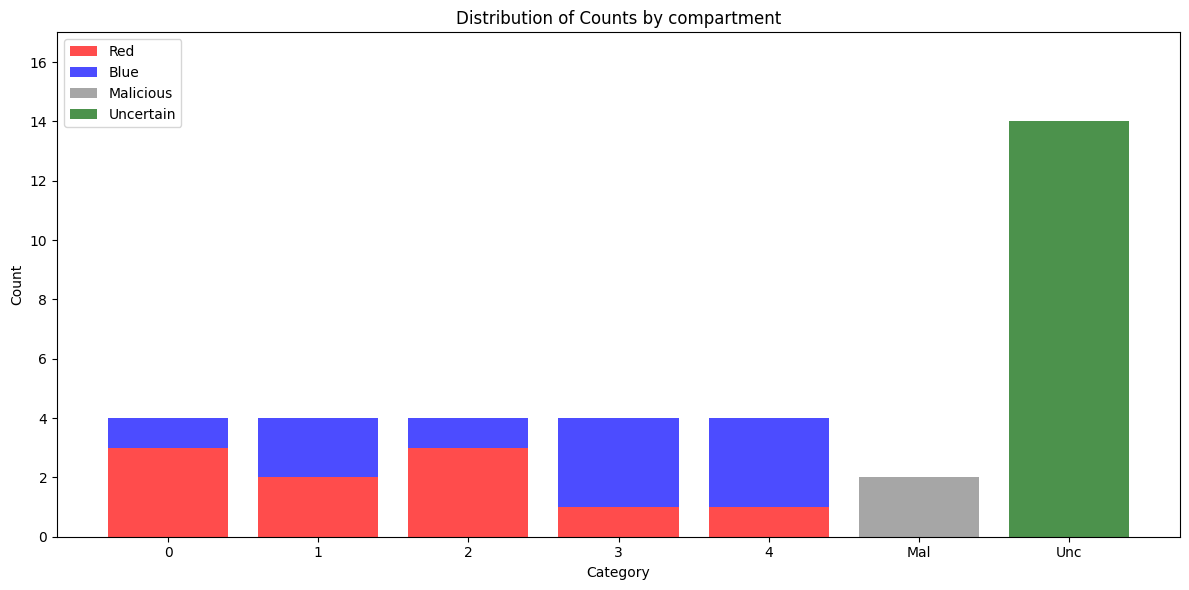

In [57]:
plot_results(red_counts, blue_counts, mal_for_each, unc_for_each)

The variant model demonstrates successful preservation of the original model's behavior with respect to the given formulas. Let's analyze each aspect:

Overall Population Balance:
The variant model maintains the same total number of entities (100) and nearly identical proportions of RED, BLUE, UNC, and MAL entities as the original model. This global preservation is crucial for maintaining similar dynamics.
RED vs. BLUE Balance:
Both models start with an equal number of RED and BLUE entities (10 each). This balance is key for the evaluation of formulas φ1, φ2, and φ3, which focus on RED dominance and majority.
Malicious Entity Presence:
The variant model slightly increases the number of MAL entities from 5 to 10, but maintains a similar proportion (5% to 10%). This change is small enough to preserve the overall behavior while allowing for the spatial distribution across nodes. This is relevant for formula φ4, which examines the evolution of malicious entities.

##Diverge

In [7]:
diverge_spec = '''
synthesisStrategy:
  searchSpace:
    - parameterName: "redFractionIn0"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn1"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn2"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn3"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn4"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "malFractionForEach"
      lowerBound: 0.0
      upperBound: 1.0
  optimization:
    name: "pso"
    constraints:
      - constraint: "redFractionIn0 + redFractionIn1 + redFractionIn2 +redFractionIn3 +redFractionIn4 <= 3.5"
      - constraint: "redFractionIn0 + redFractionIn1 + redFractionIn2 +redFractionIn3 +redFractionIn4 >= 1.5"
    properties:
      - name: "iteration"
        value: "1000"
  sampling:
    name: "lhs"
    datasetSize: 500

synthesisTask:
  type: "comparative"

  simulationSetting:
    replica: 20

  taskSpecs:
      objective: "diverge"
      distanceType: "euclidian"
      modelOriginal:
        module: "population"
        initialConfiguration: "initial"
        modelSpecification: |
          species RED;
          species BLUE;
          species UNC;
          species MAL;

          const persuasion_rate = 1.0;
          param becoming_malevolent = 0.1;

          rule UNC_to_BLUE {
            UNC-[ (%MAL>=0.5? 0:1) * #UNC * persuasion_rate * %BLUE ]-> BLUE
          }

          rule UNC_to_RED {
            UNC -[ (%MAL>=0.5? 0:1) * #UNC * persuasion_rate * %RED ]-> RED
          }

          rule UNC_to_MAL  {
            UNC-[#UNC * persuasion_rate * %MAL ]-> MAL
          }

          rule BLUE_to_UNC {
            BLUE -[ (%MAL>=0.5? 0:1) * #BLUE * persuasion_rate * %RED ]-> UNC
          }

          rule RED_to_UNC {
            RED -[ (%MAL>=0.5? 0:1) * #RED * persuasion_rate * %BLUE ]-> UNC
          }

          measure R = %RED;
          measure B = %BLUE;
          measure U = %UNC;
          measure M = %MAL;

          system initial = RED<10>|BLUE<10>|UNC<75>|MAL<5>;
      modelVariant:
        module: "population"
        initialConfiguration: "initial"
        modelSpecification: |
          const K = 5;       /* length of the ring */

          species RED of [0,K];
          species BLUE of [0,K];
          species UNC of [0,K];
          species MAL of [0,K];

          param persuasion_rate = 3.0; /* persuasion rate */
          param becoming_malevolent = 0.1;

          param totalRedAndBlue = 20;
          param totalUncAndMal = 80;

          param redFractionIn0 = 0.5;
          param redFractionIn1 = 0.5;
          param redFractionIn2 = 0.5;
          param redFractionIn3 = 0.5;
          param redFractionIn4 = 0.5;

          const redQuantityIn0 = redFractionIn0 * totalRedAndBlue / K;
          const redQuantityIn1 = redFractionIn1 * totalRedAndBlue / K;
          const redQuantityIn2 = redFractionIn2 * totalRedAndBlue / K;
          const redQuantityIn3 = redFractionIn3 * totalRedAndBlue / K;
          const redQuantityIn4 = redFractionIn4 * totalRedAndBlue / K;

          const blueQuantityIn0 = (1.0-redFractionIn0) * totalRedAndBlue / K;
          const blueQuantityIn1 = (1.0-redFractionIn1) * totalRedAndBlue / K;
          const blueQuantityIn2 = (1.0-redFractionIn2) * totalRedAndBlue / K;
          const blueQuantityIn3 = (1.0-redFractionIn3) * totalRedAndBlue / K;
          const blueQuantityIn4 = (1.0-redFractionIn4) * totalRedAndBlue / K;

          param malFractionForEach = 0.0;

          const uncQuantityInEach = (1.0-malFractionForEach) * totalUncAndMal /K;
          const malQuantityInEach = malFractionForEach * totalUncAndMal /K;


          rule UNC_to_BLUE for i in [0,K] {
            UNC[i]-[ (%MAL[i]>=0.5? 0:1) * #UNC[i] * persuasion_rate * (%BLUE[i] + %BLUE[(i+1)%K] + %BLUE[(i-1+K)%K])/3 ]-> BLUE[i]
          }

          rule UNC_to_RED for i in [0,K] {
            UNC[i]-[(%MAL[i]>=0.5? 0:1) * #UNC[i] * persuasion_rate * (%RED[i] + %RED[(i+1)%K] + %RED[(i-1+K)%K])/3 ]-> RED[i]
          }

          rule UNC_to_MAL for i in [0,K] {
            UNC[i]-[#UNC[i] * persuasion_rate * %MAL[i] ]-> MAL[i]
          }

          rule BLUE_to_UNC for i in [0,K] {
            BLUE[i]-[ (%MAL[i]>=0.5? 0:1) * #BLUE[i] * persuasion_rate * (%RED[i] + %RED[(i+1)%K] + %RED[(i-1+K)%K])/3 ]-> UNC[i]
          }

          rule RED_to_UNC for i in [0,K] {
            RED[i]-[ (%MAL[i]>=0.5? 0:1) * #RED[i] * persuasion_rate * (%BLUE[i] + %BLUE[(i+1)%K] + %BLUE[(i-1+K)%K])/3 ]-> UNC[i]
          }

          measure R = %RED[0] + %RED[1] + %RED[2] + %RED[3] + %RED[4];
          measure B = %BLUE[0] + %BLUE[1] + %BLUE[2] + %BLUE[3] + %BLUE[4];
          measure U = %UNC[0] + %UNC[1] + %UNC[2] + %UNC[3] + %UNC[4];
          measure M = %MAL[0] + %MAL[1] + %MAL[2] + %MAL[3] + %MAL[4];

          system initial = RED[0]<redQuantityIn0>|RED[1]<redQuantityIn1>|RED[2]<redQuantityIn2>|RED[3]<redQuantityIn3>|RED[4]<redQuantityIn4>|BLUE[0]<blueQuantityIn0>|BLUE[1]<blueQuantityIn1>|BLUE[2]<blueQuantityIn2>|BLUE[3]<blueQuantityIn3>|BLUE[4]<blueQuantityIn4>|UNC[0]<uncQuantityInEach>|UNC[1]<uncQuantityInEach>|UNC[2]<uncQuantityInEach>|UNC[3]<uncQuantityInEach>|UNC[4]<uncQuantityInEach>|MAL[0]<malQuantityInEach>|MAL[1]<malQuantityInEach>|MAL[2]<malQuantityInEach>|MAL[3]<malQuantityInEach>|MAL[4]<malQuantityInEach>;

      formulae: |
        measure R
        measure B
        measure M
        formula formula_stability [t=25] : \E[0,t][ R >= 1.0 ]   endformula
        formula formula_coherence [t=25] : ([ R > 3 * B ]&&(\E[0,t][ B <= 0.0])) endformula
        formula formula_red_pres [t=25] : (\G[0,t][ R >= 0.5]) endformula
        formula formula_mal_pres [t=25] : ((\E[0, 1/4 * t]([M >= 0.01]))<->(\G[3/4 * t,t]([M >= 0.25] && [M <= 0.75]))) endformula

'''

syn_rec_div = sr.perform_synthesis(diverge_spec)
print(syn_rec_div)

Optimal Coordinates: {'redFractionIn0': 0.30673558065210355, 'redFractionIn1': 0.288989005755045, 'redFractionIn2': 0.22008337989514742, 'malFractionForEach': 0.9833301428493497, 'redFractionIn3': 0.22062111557087197, 'redFractionIn4': 0.46365673357859627}
Optimal Value (Objective Function): 0.4310939894939127
Optimal Value (Surrogate Function): 0.3955828696982522


### Result

This variant model demonstrates extreme divergence from the original model's behavior. The drastic shifts in entity proportions, especially the dominance of MAL entities and the BLUE advantage over RED, fundamentally alter the system's dynamics. The behavior with respect to all four specified formulas is expected to be significantly different from the original model. This divergence allows for exploration of how the system behaves under extreme conditions, potentially revealing new insights about the robustness or vulnerabilities of the consensus mechanism in highly adversarial scenarios.

In [58]:
# Get optimal coordinates
diverge_optimal_coordinates = syn_rec_div.optimal_coordinates()

# Extract red fractions
red_fractions = {
    f'red_{i}_opt_d': diverge_optimal_coordinates[f'redFractionIn{i}']
    for i in range(5)
}

# Extract malicious fraction
mal_opt_d = diverge_optimal_coordinates['malFractionForEach']

# Calculate red and blue counts
red_counts = {
    f'red_in_{i}_d': round(red_fractions[f'red_{i}_opt_d'] * 4)
    for i in range(5)
}

blue_counts = {
    f'blue_in_{i}_d': 4 - red_counts[f'red_in_{i}_d']
    for i in range(5)
}

# Calculate malicious and uncompromised counts
mal_for_each = round(mal_opt_d * 16)
unc_for_each = 16 - mal_for_each

# Print results
print('Red Total')
print(f"Total: {sum(red_counts.values())}")
print(*red_counts.values())

print('\nBlue Total')
print(f"Total: {sum(blue_counts.values())}")
print(*blue_counts.values())

print('\nMalicious for each')
print(mal_for_each)

print('\nUncompromised for each')
print(unc_for_each)

Red Total
Total: 6
1 1 1 1 2

Blue Total
Total: 14
3 3 3 3 2

Malicious for each
16

Uncompromised for each
0


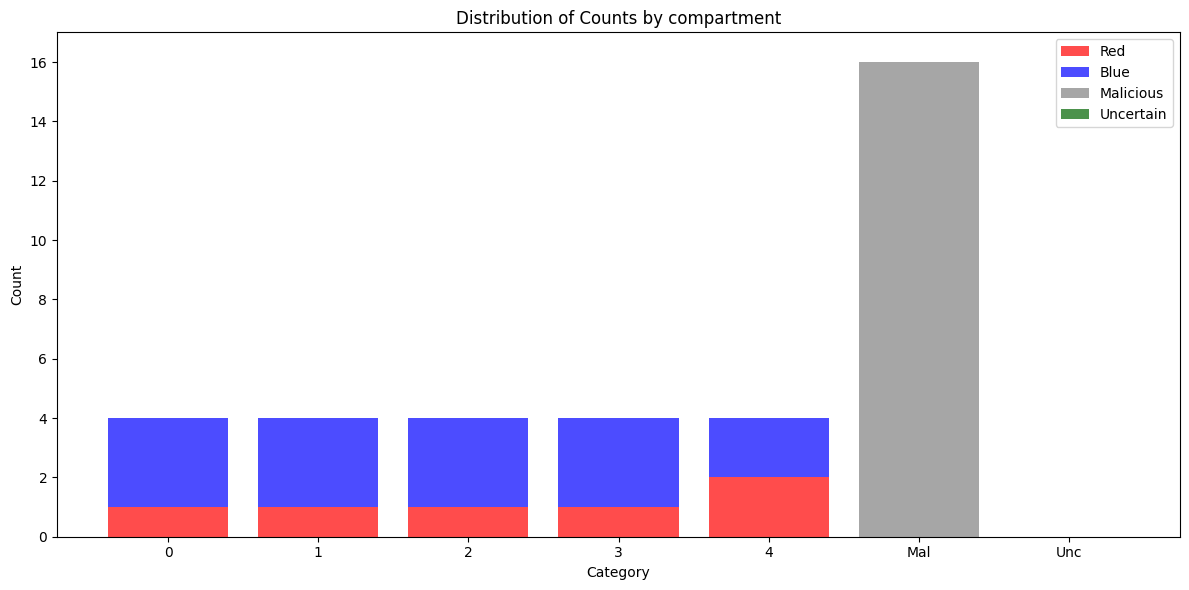

In [59]:
plot_results(red_counts, blue_counts, mal_for_each, unc_for_each)

In [ ]:
preserve_optimal_coordinates = syn_rec_pres.optimal_coordinates()

red_fractions = {
    f'red_{i}_opt_p': preserve_optimal_coordinates[f'redFractionIn{i}']
    for i in range(5)
}

mal_opt_p = preserve_optimal_coordinates['malFractionForEach']

red_counts = {
    f'red_in_{i}_p': round(red_fractions[f'red_{i}_opt_p'] * 4)
    for i in range(5)
}

blue_counts = {
    f'blue_in_{i}_p': 4 - red_counts[f'red_in_{i}_p']
    for i in range(5)
}

mal_for_each = round(mal_opt_p * 16)
unc_for_each = 16 - mal_for_each

print('Red Total')
print(f"Total: {sum(red_counts.values())}")
print(*red_counts.values())

print('\nBlue Total')
print(f"Total: {sum(blue_counts.values())}")
print(*blue_counts.values())

print('\nMalicious for each')
print(mal_for_each)

print('\nUncompromised for each')
print(unc_for_each)

##Improve

In [8]:
improve_spec = '''
synthesisStrategy:
  searchSpace:
    - parameterName: "redFractionIn0"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn1"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn2"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn3"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "redFractionIn4"
      lowerBound: 0.1
      upperBound: 1.0
    - parameterName: "malFractionForEach"
      lowerBound: 0.0
      upperBound: 1.0
  optimization:
    name: "pso"
    constraints:
      - constraint: "redFractionIn0 + redFractionIn1 + redFractionIn2 +redFractionIn3 +redFractionIn4 <= 3.5"
      - constraint: "redFractionIn0 + redFractionIn1 + redFractionIn2 +redFractionIn3 +redFractionIn4 >= 1.5"
    properties:
      - name: "iteration"
        value: "1000"
  sampling:
    name: "lhs"
    datasetSize: 500

synthesisTask:
  type: "comparative"

  simulationSetting:
    replica: 20

  taskSpecs:
      objective: "improve"
      distanceType: "euclidian"
      modelOriginal:
        module: "population"
        initialConfiguration: "initial"
        modelSpecification: |
          species RED;
          species BLUE;
          species UNC;
          species MAL;

          const persuasion_rate = 1.0;
          param becoming_malevolent = 0.1;

          rule UNC_to_BLUE {
            UNC-[ (%MAL>=0.5? 0:1) * #UNC * persuasion_rate * %BLUE ]-> BLUE
          }

          rule UNC_to_RED {
            UNC -[ (%MAL>=0.5? 0:1) * #UNC * persuasion_rate * %RED ]-> RED
          }

          rule UNC_to_MAL  {
            UNC-[#UNC * persuasion_rate * %MAL ]-> MAL
          }

          rule BLUE_to_UNC {
            BLUE -[ (%MAL>=0.5? 0:1) * #BLUE * persuasion_rate * %RED ]-> UNC
          }

          rule RED_to_UNC {
            RED -[ (%MAL>=0.5? 0:1) * #RED * persuasion_rate * %BLUE ]-> UNC
          }

          measure R = %RED;
          measure B = %BLUE;
          measure U = %UNC;
          measure M = %MAL;

          system initial = RED<10>|BLUE<10>|UNC<75>|MAL<5>;
      modelVariant:
        module: "population"
        initialConfiguration: "initial"
        modelSpecification: |
          const K = 5;       /* length of the ring */

          species RED of [0,K];
          species BLUE of [0,K];
          species UNC of [0,K];
          species MAL of [0,K];

          param persuasion_rate = 3.0; /* persuasion rate */
          param becoming_malevolent = 0.1;

          param totalRedAndBlue = 20;
          param totalUncAndMal = 80;

          param redFractionIn0 = 0.5;
          param redFractionIn1 = 0.5;
          param redFractionIn2 = 0.5;
          param redFractionIn3 = 0.5;
          param redFractionIn4 = 0.5;

          const redQuantityIn0 = redFractionIn0 * totalRedAndBlue / K;
          const redQuantityIn1 = redFractionIn1 * totalRedAndBlue / K;
          const redQuantityIn2 = redFractionIn2 * totalRedAndBlue / K;
          const redQuantityIn3 = redFractionIn3 * totalRedAndBlue / K;
          const redQuantityIn4 = redFractionIn4 * totalRedAndBlue / K;

          const blueQuantityIn0 = (1.0-redFractionIn0) * totalRedAndBlue / K;
          const blueQuantityIn1 = (1.0-redFractionIn1) * totalRedAndBlue / K;
          const blueQuantityIn2 = (1.0-redFractionIn2) * totalRedAndBlue / K;
          const blueQuantityIn3 = (1.0-redFractionIn3) * totalRedAndBlue / K;
          const blueQuantityIn4 = (1.0-redFractionIn4) * totalRedAndBlue / K;

          param malFractionForEach = 0.0;

          const uncQuantityInEach = (1.0-malFractionForEach) * totalUncAndMal /K;
          const malQuantityInEach = malFractionForEach * totalUncAndMal /K;


          rule UNC_to_BLUE for i in [0,K] {
            UNC[i]-[ (%MAL[i]>=0.5? 0:1) * #UNC[i] * persuasion_rate * (%BLUE[i] + %BLUE[(i+1)%K] + %BLUE[(i-1+K)%K])/3 ]-> BLUE[i]
          }

          rule UNC_to_RED for i in [0,K] {
            UNC[i]-[(%MAL[i]>=0.5? 0:1) * #UNC[i] * persuasion_rate * (%RED[i] + %RED[(i+1)%K] + %RED[(i-1+K)%K])/3 ]-> RED[i]
          }

          rule UNC_to_MAL for i in [0,K] {
            UNC[i]-[#UNC[i] * persuasion_rate * %MAL[i] ]-> MAL[i]
          }

          rule BLUE_to_UNC for i in [0,K] {
            BLUE[i]-[ (%MAL[i]>=0.5? 0:1) * #BLUE[i] * persuasion_rate * (%RED[i] + %RED[(i+1)%K] + %RED[(i-1+K)%K])/3 ]-> UNC[i]
          }

          rule RED_to_UNC for i in [0,K] {
            RED[i]-[ (%MAL[i]>=0.5? 0:1) * #RED[i] * persuasion_rate * (%BLUE[i] + %BLUE[(i+1)%K] + %BLUE[(i-1+K)%K])/3 ]-> UNC[i]
          }

          measure R = %RED[0] + %RED[1] + %RED[2] + %RED[3] + %RED[4];
          measure B = %BLUE[0] + %BLUE[1] + %BLUE[2] + %BLUE[3] + %BLUE[4];
          measure U = %UNC[0] + %UNC[1] + %UNC[2] + %UNC[3] + %UNC[4];
          measure M = %MAL[0] + %MAL[1] + %MAL[2] + %MAL[3] + %MAL[4];

          system initial = RED[0]<redQuantityIn0>|RED[1]<redQuantityIn1>|RED[2]<redQuantityIn2>|RED[3]<redQuantityIn3>|RED[4]<redQuantityIn4>|BLUE[0]<blueQuantityIn0>|BLUE[1]<blueQuantityIn1>|BLUE[2]<blueQuantityIn2>|BLUE[3]<blueQuantityIn3>|BLUE[4]<blueQuantityIn4>|UNC[0]<uncQuantityInEach>|UNC[1]<uncQuantityInEach>|UNC[2]<uncQuantityInEach>|UNC[3]<uncQuantityInEach>|UNC[4]<uncQuantityInEach>|MAL[0]<malQuantityInEach>|MAL[1]<malQuantityInEach>|MAL[2]<malQuantityInEach>|MAL[3]<malQuantityInEach>|MAL[4]<malQuantityInEach>;

      formulae: |
        measure R
        measure B
        measure M
        formula formula_stability [t=25] : \E[0,t][ R >= 1.0 ]   endformula
        formula formula_coherence [t=25] : ([ R > 3 * B ]&&(\E[0,t][ B <= 0.0])) endformula
        formula formula_red_pres [t=25] : (\G[0,t][ R >= 0.5]) endformula
        formula formula_mal_pres [t=25] : ((\E[0, 1/4 * t]([M >= 0.01]))<->(\G[3/4 * t,t]([M >= 0.25] && [M <= 0.75]))) endformula


'''
syn_rec_imp= sr.perform_synthesis(improve_spec)
print(syn_rec_imp)

Optimal Coordinates: {'redFractionIn0': 0.6853481025061248, 'redFractionIn1': 0.7738049378368143, 'redFractionIn2': 0.7464633578349728, 'malFractionForEach': 0.026395489587406503, 'redFractionIn3': 0.6725714565413752, 'redFractionIn4': 0.580528712979949}
Optimal Value (Objective Function): 0.6478826387396462
Optimal Value (Surrogate Function): 0.6173405805824802


### Result

This variant model demonstrates significant improvements over the original model's behavior, particularly in terms of achieving RED dominance and ensuring system security. The shift in entity proportions, especially the RED advantage over BLUE and the elimination of MAL entities, enhances the system's ability to satisfy the specified formulas.

In [60]:
# Get optimal coordinates
improve_optimal_coordinates = syn_rec_imp.optimal_coordinates()

# Extract red fractions
red_fractions = {
    f'red_{j}_opt_i': improve_optimal_coordinates[f'redFractionIn{j}']
    for j in range(5)
}

# Extract malicious fraction
mal_opt_i = improve_optimal_coordinates['malFractionForEach']

# Calculate red and blue counts
red_counts = {
    f'red_in_{j}_i': round(red_fractions[f'red_{j}_opt_i'] * 4)
    for j in range(5)
}

blue_counts = {
    f'blue_in_{j}_i': 4 - red_counts[f'red_in_{j}_i']
    for j in range(5)
}

# Calculate malicious and uncompromised counts
mal_for_each = round(mal_opt_i * 16)
unc_for_each = 16 - mal_for_each

# Print results
print('Red Total')
print(f"Total: {sum(red_counts.values())}")
print(*red_counts.values())

print('\nBlue Total')
print(f"Total: {sum(blue_counts.values())}")
print(*blue_counts.values())

print('\nMalicious for each')
print(mal_for_each)

print('\nUncompromised for each')
print(unc_for_each)

Red Total
Total: 14
3 3 3 3 2

Blue Total
Total: 6
1 1 1 1 2

Malicious for each
0

Uncompromised for each
16


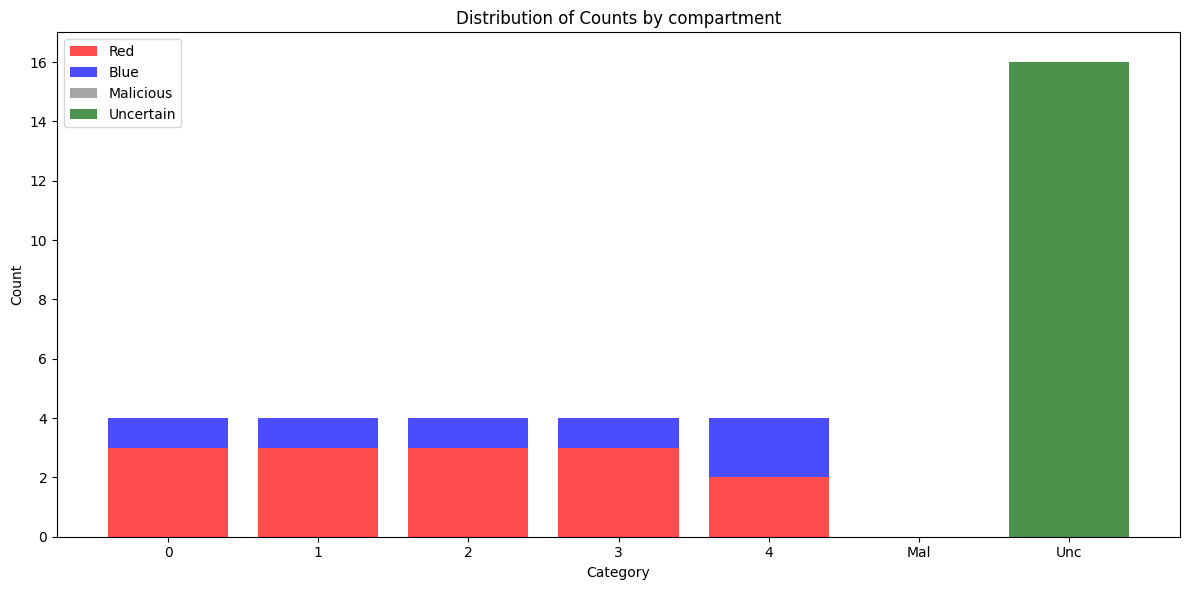

In [61]:
plot_results(red_counts, blue_counts, mal_for_each, unc_for_each)